## Solving bidomain equations on the ventricle with modified FitzHugh-Nagumo model

### Importing required libraries

In [1]:
%cd ../../..
from src.models.dynamics_models import *
from src.models.cell_models import *
from src.utils import *
import ufl

/home/drvinko/Desktop/Modeliranje-biofizike-srcanog-tkiva


### Defining a domain, cell model and dynamics model and visualizing initial data

In [2]:
domain = heart_ventricle(0.25)
x = ufl.SpatialCoordinate(domain)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 6 (Ellipse)
Info    : [ 60%] Meshing curve 7 (Ellipse)
Info    : [ 80%] Meshing curve 9 (Ellipse)
Info    : [ 90%] Meshing curve 10 (Ellipse)
Info    : [100%] Meshing curve 11 (Line)
Info    : Done meshing 1D (Wall 0.00780396s, CPU 0.008123s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Surface of Revolution, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Surface of Revolution, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 80%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.165288s, CPU 0.164321s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 3157 nodes...

In [3]:
class Model(BidomainModel):
    def initial_V_m(self):
        self.V_m_n.x.array[:] = -85
        locator = lambda x: x[2] < -7
        cells = fem.locate_dofs_geometrical(self.V1, locator)
        self.V_m_n.x.array[cells] = np.full_like(cells, -50)

    def conductivity(self):
        # Muscle fibres
        x_c, y_c = 0.2, 1
        self.fibers = ufl.as_vector(
            [
                -(x[1] - y_c) / ufl.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
                (x[0] - x_c) / ufl.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
                0,
            ]
        )
        self.normals = ufl.as_vector([0, 0, 1])

        # Healthy conductivities
        self.M_i = (
            self.SIGMA_IT * ufl.Identity(3)
            + (self.SIGMA_IL - self.SIGMA_IT) * ufl.outer(self.fibers, self.fibers)
            + (self.SIGMA_IN - self.SIGMA_IT) * ufl.outer(self.normals, self.normals)
        )
        self.M_e = (
            self.SIGMA_ET * ufl.Identity(3)
            + (self.SIGMA_EL - self.SIGMA_ET) * ufl.outer(self.fibers, self.fibers)
            + (self.SIGMA_EN - self.SIGMA_ET) * ufl.outer(self.normals, self.normals)
        )

In [4]:
cell_model = ReparametrizedFitzHughNagumo(domain)
model = Model(domain, cell_model)

In [5]:
model.plot_initial_V_m(
    show_mesh=False,
    shadow=True,
    function_name="",
    save_to="figures/ventricle/MFN_applied_current.pdf",
)

Widget(value='<iframe src="http://localhost:43073/index.html?ui=P_0x7fc89023d610_0&reconnect=auto" class="pyvi…

### Solving equations with given parameters

In [6]:
model.solve(
    T=800,
    steps=800,
    save_to="ventricle/bidomain_MFN.mp4",
    signal_point=[0.0, -1.5, -6.0],
    checkpoints=[200, 400, 600, 800],
    checkpoint_file="figures/ventricle/bidomain_MFN",
)

Solving problem: 100%|██████████| 800/800 [52:58<00:00,  3.97s/it]


### Plotting a fiber orientations

In [7]:
x_c, y_c = 0, 0
plot_vector_field(
    domain,
    lambda x: (
        -(x[1] - y_c) / np.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
        (x[0] - x_c) / np.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
        0,
    ),
    0.02,
    0.3,
    save_to="figures/ventricle/MFN_fibers.pdf",
)

Widget(value='<iframe src="http://localhost:43073/index.html?ui=P_0x7fc7b005ee10_1&reconnect=auto" class="pyvi…

### Plotting a final plot of transmembrane potential

In [8]:
plot_function(model.V_m_n, "V_m", show_mesh=False)

### Plotting a transmembrane potential in a given signal point

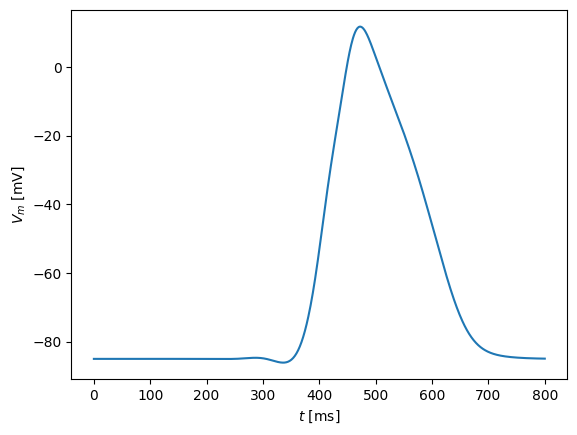

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('d8eb557559df9d1c40d0ccdcb8f576a4_12622d')
ERROR:wslink.protocol:Traceback (most recent call last):
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/wslink/protocol.py", line 332, in onMessage
    results = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 30, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
                ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: 'd8eb557559df9d1c40d0ccdcb8f576a4_12622d'



In [9]:
model.plot_signal()